In [35]:
import json
import csv
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime

In [23]:
#Se lee la data entera
with open('../data/subreddits.json', 'r') as file:
    data = json.load(file)

In [27]:
#Dataframe para los subreddits
subreddit_data = pd.DataFrame({
    'subreddit_id': range(len(data)),  #Se crea un id para cada subreddit
    'tittleSubreddit': [sub['tittleSubreddit'] for sub in data],
    'subscribersReddit': [sub['subscribersReddit'] for sub in data],
    'descriptionReddit': [sub['descriptionReddit'] for sub in data],
    'createdReddit': [sub['createdReddit'] for sub in data],
    'subreddit_url': [sub['subreddit_url'] for sub in data]
})

#Dataframe para los posts
posts_data = []
for i, sub in enumerate(data):
    for post in sub['upVotedPosts']:
        posts_data.append({
            'subreddit_id': i,  #foreign key
            'author': post['author'],
            'titlePost': post['titlePost'],
            'selftext': post['selftext'],
            'createdPost': post['createdPost'],
            'scorePost': post['scorePost'],
            'upVotedRatio': post['upVotedRatio'],
            'upVotes': post['upVotes'],
            'flair': post['flair'],
            'commentsPost': post['commentsPost'],
            'urlPost': post['urlPost']
        })

posts_data = pd.DataFrame(posts_data)

In [25]:
subreddit_data.head()

,subreddit_id,tittleSubreddit,subscribersReddit,descriptionReddit,createdReddit,subreddit_url
0,0,Home,243743,,1.232850e+09,https://www.reddit.com/r/Home/
1,1,AskReddit,48481312,r/AskReddit is the place to ask and answer tho...,1.201233e+09,https://www.reddit.com/r/AskReddit/
2,2,NoStupidQuestions,4980890,Ask away!\n\nDisclaimer: This is an anonymous ...,1.359795e+09,https://www.reddit.com/r/NoStupidQuestions/
3,3,BaldursGate3,2364982,"A community all about Baldur's Gate III, the r...",1.559227e+09,https://www.reddit.com/r/BaldursGate3/
4,4,facepalm,8265075,/r/facepalm - please sir can I have some more?,1.251449e+09,https://www.reddit.com/r/facepalm/


In [ ]:
posts_data.head()

,subreddit_id,author,titlePost,createdPost,scorePost,upVotedRatio,upVotes,flair,commentsPost,urlPost
0,0,elias3663,What is the price range for a house like this?,2023-08-18 10:17:43,11633,0.92,11633,None,1727,https://www.reddit.com/gallery/15ugiho
1,0,deckin-designer,Why is there a door above the garage?,2023-05-18 16:41:57,6026,0.96,6026,None,1700,https://i.redd.it/tjh8baqltn0b1.jpg
2,0,effectsjay,Can I fix these garage door torsion springs by...,2023-08-26 19:44:33,5581,0.86,5581,None,3644,https://i.redd.it/kiqk8j2cdikb1.jpg
3,0,unsold_dildo,What you call these types of designs,2023-08-21 17:37:07,2824,0.96,2824,None,579,https://i.redd.it/5efyh6f12ijb1.jpg
4,0,Mysterious_Tea_4748,An inspector said this is termite damage and m...,2023-07-28 17:40:05,2692,0.94,2692,None,952,https://i.redd.it/wfgdih7psqeb1.jpg


**Procesamiento subreddits**

In [43]:
#Cambiamos el formato de las fechas en posts_data a datetime
posts_data['createdPost'] = pd.to_datetime(posts_data['createdPost'], unit='s')
#Debido a que pocos registros tienen la descripción vacía, se puede asumir su uso.
numNulls = (subreddit_data["descriptionReddit"] == "").sum()
numNulls 

np.int64(1)

***Procesamiento posts***

In [42]:
# Identificamos y eliminamos las publicaciones que no comienzan con las URLs especificadas
posts_data = posts_data.drop(posts_data[~posts_data["urlPost"].str.startswith(("https://www.reddit", "https://v.redd", "https://i.redd"))].index)
posts_data = posts_data.reset_index(drop=True)
posts_data["urlPost"]

0        https://www.reddit.com/gallery/15ugiho
1           https://i.redd.it/tjh8baqltn0b1.jpg
2           https://i.redd.it/kiqk8j2cdikb1.jpg
3           https://i.redd.it/5efyh6f12ijb1.jpg
4           https://i.redd.it/wfgdih7psqeb1.jpg
                          ...                  
25386       https://i.redd.it/xsxkwdd0g4xa1.jpg
25387       https://i.redd.it/3v9263uo3b2b1.jpg
25388       https://i.redd.it/wod3okj7zzva1.jpg
25389       https://i.redd.it/o7ahwam64esa1.jpg
25390       https://i.redd.it/62wy4d8x0vxb1.jpg
Name: urlPost, Length: 25391, dtype: object

In [33]:
#Se elimina la columna 'selftext' debido alto porcentage de vacios
numNulls = (posts_data["selftext"] == "").sum()
percentage = numNulls / len(posts_data["selftext"]) * 100

print("Total de registros en la columna 'selftext':", len(posts_data["selftext"]))
print("Porcentaje de registros vacios en la columna 'selftext':", percentage, "%")
posts_data = posts_data.drop(columns=["selftext"])

Total de registros en la columna 'selftext': 25391
Porcentaje de registros vacios en la columna 'selftext': 68.35099050844788 %


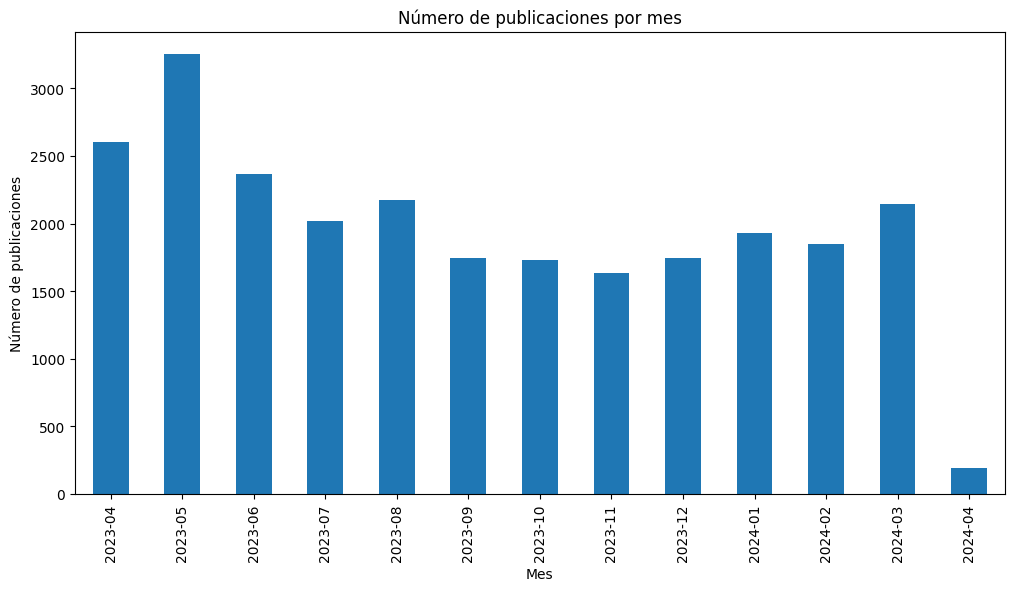

In [44]:
postsMonth = posts_data['createdPost'].dt.to_period('M').value_counts().sort_index()
date_range = pd.period_range(start=postsMonth.index.min(), end=postsMonth.index.max(), freq='M')
postsMonth = postsMonth.reindex(date_range, fill_value=0)

plt.figure(figsize=(12, 6))
postsMonth.plot(kind='bar')
plt.title('Número de publicaciones por mes')
plt.xlabel('Mes')
plt.ylabel('Número de publicaciones')
plt.show()

In [45]:
subreddit_data.to_csv('../data/subreddit_data.csv', index=False)
posts_data.to_csv('../data/posts_data.csv', index=False)